# 월간 데이콘 법원 판결 예측 AI 경진대회
Dataset Info.
* ID : 사건 샘플 ID
* first_party : 사건의 첫 번째 당사자
* second_party : 사건의 두 번째 당사자
* facts : 사건 내용
* first_party_winner : 첫 번째 당사자의 승소 여부 (0 : 패배, 1 : 승리)

**첫 번째 당사자의 승소 여부 예측하기**

문장 토큰화 -> 단계를 거치고 -> 단어 토큰화

데이터를 확실하게 살펴보고
재범률 높은 거 확인

워드클라우드
유형별 분류한 다음에
1번이 이긴 경우 워드클라우드
2번이 이긴 경우 워드클라우드

워드 수 확인
키워드 추출
-> 유형분류하는게 맞는 건가?

contain하는 방법
str.contain

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import warnings
warnings.filterwarnings(action='ignore')

In [29]:
train = pd.read_csv('/content/drive/MyDrive/DACON_JudgmentPrediction/data/train.csv')
train_1 = pd.read_csv('/content/drive/MyDrive/DACON_JudgmentPrediction/data/train_1.csv',encoding='cp949')
test = pd.read_csv('/content/drive/MyDrive/DACON_JudgmentPrediction/data/test.csv')


In [30]:
df=train

In [4]:
train_1.head(20)

,ID,first_party,second_party,facts,first_party_winner,Unnamed: 5
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1,Herman A. Thompson
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0,Stephen Duncan
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1,"Tony Patterson, Warden, et al."
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0,Linkletter
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1,Alabama
5,TRAIN_0005,"C & A Carbone, Inc., et al.",Town of Clarkstown,"A New York town, Clarkstown, allowed a contrac...",1,Town of Clarkstown
6,TRAIN_0006,"David Jennings, et al.","Alejandro Rodriguez, et al.",Sections of the Immigration and Nationality Ac...,1,"Alejandro Rodriguez, et al."
7,TRAIN_0007,"US Airways, Inc.",Barnett,"In 1990, Robert Barnett injured his back while...",1,Barnett
8,TRAIN_0008,"Ron Davis, Acting Warden",Hector Ayala,"Hector Ayala, a Hispanic man, was charged with...",1,Hector Ayala
9,TRAIN_0009,Paul A. McDaniel,"Selma Cash Paty, et al.","Since its first state Constitution in 1796, Te...",1,"Selma Cash Paty, et al."


In [5]:
df.first_party_winner.value_counts()

1    1649
0     829
Name: first_party_winner, dtype: int64

2478개의 사건

In [6]:
len(df.first_party.unique()),len(df.second_party.unique())

(2110, 1974)

In [7]:
import pandas as pd
pd.set_option('display.max_rows', 10000)

In [8]:
df['first_party'].value_counts().loc[lambda x:x>1]

United States                                                                                154
Illinois                                                                                       9
Maryland                                                                                       8
Florida                                                                                        8
New York                                                                                       7
United States of America                                                                       7
Michigan                                                                                       7
California                                                                                     7
Federal Election Commission                                                                    5
Arizona                                                                                        5
National Association for the A

In [9]:
df['second_party'].value_counts().loc[lambda x:x>1]

United States                                                                                               240
California                                                                                                   19
United States of America                                                                                     15
Illinois                                                                                                     13
Federal Communications Commission                                                                            10
Florida                                                                                                      10
Louisiana                                                                                                     9
Texas                                                                                                         9
New York                                                                                                

In [10]:
#first, second 상관없이 죄저지른 개수보깅
#일단 죄없는애들 지우고 개수보자.
train_1['Unnamed: 5'].value_counts()

United States                                                                                                                                                                               166
California                                                                                                                                                                                   14
United States of America                                                                                                                                                                     10
Louisiana                                                                                                                                                                                    10
Texas                                                                                                                                                                                         8
Georgia                                 

당사자에 따라 승소, 패소 확률이 크게 다르지 않음. ex) Unite States가 승소횟수랑 패소한 횟수가 비슷함.

In [13]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [14]:
import nltk

In [15]:
for i in range(2477):
  df.facts[i] = nltk.sent_tokenize(df.facts[i])

In [18]:
df['facts'][0]

['On June 27, 1962, Phil St. Amant, a candidate for public office, made a television speech in Baton Rouge, Louisiana.',
 'During this speech, St. Amant accused his political opponent of being a Communist and of being involved in criminal activities with the head of the local Teamsters Union.',
 'Finally, St. Amant implicated Herman Thompson, an East Baton Rouge deputy sheriff, in a scheme to move money between the Teamsters Union and St. Amant’s political opponent.',
 'Thompson successfully sued St. Amant for defamation.',
 'Louisiana’s First Circuit Court of Appeals reversed, holding that Thompson did not show St. Amant acted with “malice.”  Thompson then appealed to the Supreme Court of Louisiana.',
 'That court held that, although public figures forfeit some of their First Amendment protection from defamation, St. Amant accused Thompson of a crime with utter disregard of whether the remarks were true.',
 'Finally, that court held that the First Amendment protects uninhibited, robus

In [28]:
df=train
train.head(5)

,ID,first_party,second_party,facts,first_party_winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"[On June 27, 1962, Phil St. Amant, a candidate...",1
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,[Ramon Nelson was riding his bike when he suff...,0
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",[An Alabama state court convicted Billy Joe Ma...,1
3,TRAIN_0003,Linkletter,Walker,[Victor Linkletter was convicted in state cour...,0
4,TRAIN_0004,William Earl Fikes,Alabama,"[On April 24, 1953 in Selma, Alabama, an intru...",1


In [32]:
WordPunctTokenizer().tokenize(train['facts'][0])

['On',
 'June',
 '27',
 ',',
 '1962',
 ',',
 'Phil',
 'St',
 '.',
 'Amant',
 ',',
 'a',
 'candidate',
 'for',
 'public',
 'office',
 ',',
 'made',
 'a',
 'television',
 'speech',
 'in',
 'Baton',
 'Rouge',
 ',',
 'Louisiana',
 '.',
 'During',
 'this',
 'speech',
 ',',
 'St',
 '.',
 'Amant',
 'accused',
 'his',
 'political',
 'opponent',
 'of',
 'being',
 'a',
 'Communist',
 'and',
 'of',
 'being',
 'involved',
 'in',
 'criminal',
 'activities',
 'with',
 'the',
 'head',
 'of',
 'the',
 'local',
 'Teamsters',
 'Union',
 '.',
 'Finally',
 ',',
 'St',
 '.',
 'Amant',
 'implicated',
 'Herman',
 'Thompson',
 ',',
 'an',
 'East',
 'Baton',
 'Rouge',
 'deputy',
 'sheriff',
 ',',
 'in',
 'a',
 'scheme',
 'to',
 'move',
 'money',
 'between',
 'the',
 'Teamsters',
 'Union',
 'and',
 'St',
 '.',
 'Amant',
 '’',
 's',
 'political',
 'opponent',
 '.',
 'Thompson',
 'successfully',
 'sued',
 'St',
 '.',
 'Amant',
 'for',
 'defamation',
 '.',
 'Louisiana',
 '’',
 's',
 'First',
 'Circuit',
 'Court',


In [33]:
from nltk.tokenize import WordPunctTokenizer

for i in range(2477):
  df['facts'][i] = WordPunctTokenizer().tokenize(df['facts'][i])

In [34]:
from collections import Counter


In [38]:
token_list =[]

for i in range(2477):
  token_list += df['facts'][i]

In [39]:
data = Counter(token_list)
data2 = data.most_common(150)
data3 = dict(data2)

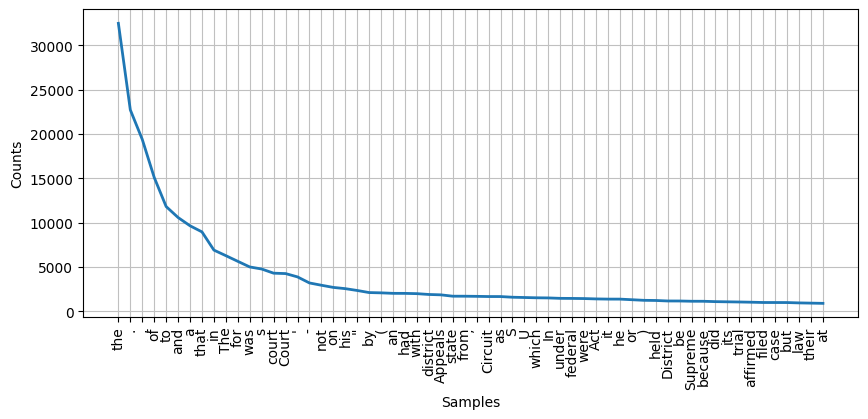

<Axes: xlabel='Samples', ylabel='Counts'>

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,4))
data4 = nltk.Text(token_list, name=" 다빈도 단어 그래프 출력하기")
data4.plot(60)

불용어 제거 안했다잉 다시한당

In [42]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [47]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

data4 = [each_word for each_word in token_list if each_word not in stopwords.words()]
data4

['On',
 'June',
 '27',
 ',',
 '1962',
 ',',
 'Phil',
 'St',
 '.',
 'Amant',
 ',',
 'candidate',
 'public',
 'office',
 ',',
 'made',
 'television',
 'speech',
 'Baton',
 'Rouge',
 ',',
 'Louisiana',
 '.',
 'During',
 'speech',
 ',',
 'St',
 '.',
 'Amant',
 'accused',
 'political',
 'opponent',
 'Communist',
 'involved',
 'criminal',
 'activities',
 'head',
 'local',
 'Teamsters',
 'Union',
 '.',
 'Finally',
 ',',
 'St',
 '.',
 'Amant',
 'implicated',
 'Herman',
 'Thompson',
 ',',
 'East',
 'Baton',
 'Rouge',
 'deputy',
 'sheriff',
 ',',
 'scheme',
 'move',
 'money',
 'Teamsters',
 'Union',
 'St',
 '.',
 'Amant',
 '’',
 'political',
 'opponent',
 '.',
 'Thompson',
 'successfully',
 'sued',
 'St',
 '.',
 'Amant',
 'defamation',
 '.',
 'Louisiana',
 '’',
 'First',
 'Circuit',
 'Court',
 'Appeals',
 'reversed',
 ',',
 'holding',
 'Thompson',
 'show',
 'St',
 '.',
 'Amant',
 'acted',
 '“',
 'malice',
 '.”',
 'Thompson',
 'appealed',
 'Supreme',
 'Court',
 'Louisiana',
 '.',
 'That',
 'court